In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.init as init

import numpy as np
import matplotlib.pyplot as plt

from utils.prune import apply_mask
from utils.count_improvement import improvements

In [9]:
# Verificar si la GPU está disponible y establecer el dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 3 * 3, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 128 * 3 * 3)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [11]:
net = Net().to(device)
varianzas_net = Net().to(device)
individuo = Net().to(device)

Cargamos los datos

In [12]:
# Definimos el transform para los datos de MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Cargamos el dataset de MNIST
train_dataset = datasets.MNIST('./../data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./../data', train=False, download=True, transform=transform)

# Definimos los DataLoaders para los conjuntos de entrenamiento y prueba
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False, num_workers=4)

In [13]:
# Definimos la función de pérdida para calcular el error
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

Realizamos el "entrenamiento"

In [14]:
# train loop
train_loss = []
train_loss_mean = []
test_accuracies = []
n_individuo = 1
accuracy_threshold = 0.99

# Multiplicamos los pesos de varianzas para que sean numero sgrandes
with torch.no_grad():
    for param in varianzas_net.parameters():
        param *= 10000

#Guardo el mejor individuo y la red original que tendrá que ser reestablecida cad epoca
best_individo_state_dict = individuo.state_dict()
net_state_dict = net.state_dict()

#train loop
while True:
    net.load_state_dict(net_state_dict)
    if n_individuo == 1:
        print(f" --------------------- Individuo {n_individuo} --------------------- ")

        masked_net = apply_mask(net, individuo)

        masked_net.train()
        running_loss = 0.0
        # Train for 1 epoch
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = masked_net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_loss.append(running_loss / len(train_loader))

        masked_net.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data in test_loader:
                images, labels = data[0].to(device), data[1].to(device)
                outputs = masked_net(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = correct / total
        #train_loss_mean.append(np.mean(train_loss))
        test_accuracies.append(accuracy)
        #print(f"Accuracy: {accuracy}, loss mean: {train_loss_mean[-1]}")
        print(f"Accuracy: {accuracy}", f"Loss: {train_loss[-1]}")
        best_loss = train_loss[-1]
        if accuracy > accuracy_threshold:
            break
        n_individuo += 1

        #sumamos varianzas para crear un nuevo individuo desde el anterior
        nuevo_individuo = Net().to(device)
        state_dict_ind = individuo.state_dict()
        state_dict_var = varianzas_net.state_dict()
        state_dict_suma = {}

        for key in state_dict_ind:
            if state_dict_ind[key].size() == state_dict_var[key].size():  
                std_dev = state_dict_var[key]
                noise = torch.normal(0, torch.abs(std_dev))
                state_dict_suma[key] = state_dict_ind[key] + torch.sign(std_dev) * noise
            else:
                state_dict_suma[key] = state_dict_ind[key]

        nuevo_individuo.load_state_dict(state_dict_suma)
        
    else:
        print(f" --------------------- Individuo {n_individuo} --------------------- ")

        masked_net = apply_mask(net, nuevo_individuo)

        masked_net.train()
        running_loss = 0.0
        # Train for 1 epoch
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = masked_net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_loss.append(running_loss / len(train_loader))

        masked_net.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data in test_loader:
                images, labels = data[0].to(device), data[1].to(device)
                outputs = masked_net(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = correct / total
        test_accuracies.append(accuracy)
        print(f"Accuracy: {accuracy}", f"Loss: {train_loss[-1]}")
        if accuracy > accuracy_threshold:
            break

        # Verificamos que individuo tiene mejor desempeño
        if train_loss[-1] < best_loss:
            print("Nuevo mejor individuo")
            best_loss = train_loss[-1]
            best_individo_state_dict = nuevo_individuo.state_dict()
        
        # actualizamos el individuo
        individuo.load_state_dict(best_individo_state_dict)

        if n_individuo >10:
            # actualizmos el vector de varianzas
            print("Aumentando varianzas")
            if improvements(train_loss) > 2:## +mejoras que peoras (lejos de la solucion)
                with torch.no_grad():
                    for param in varianzas_net.parameters():
                        param *= (1/0.82)

            elif improvements(train_loss) < 2: ## -mejoras que peoras (cerca de la solucion)
                print("Disminuyendo varianzas")
                with torch.no_grad():
                    for param in varianzas_net.parameters():
                        param *= 0.82
        
            else:
                pass

        #sumamos varianzas para crear un nuevo individuo desde el anterior
        nuevo_individuo = Net().to(device)
        state_dict_ind = individuo.state_dict()
        state_dict_var = varianzas_net.state_dict()
        state_dict_suma = {}

        for key in state_dict_ind:
            if state_dict_ind[key].size() == state_dict_var[key].size():  
                std_dev = state_dict_var[key]
                noise = torch.normal(0, torch.abs(std_dev))
                state_dict_suma[key] = state_dict_ind[key] + torch.sign(std_dev) * noise
            else:
                state_dict_suma[key] = state_dict_ind[key]

        nuevo_individuo.load_state_dict(state_dict_suma)

        n_individuo += 1         

 --------------------- Individuo 1 --------------------- 
Accuracy: 0.9811 Loss: 0.19565912786630918
 --------------------- Individuo 2 --------------------- 
Accuracy: 0.986 Loss: 0.16690143446417163
Nuevo mejor individuo
 --------------------- Individuo 3 --------------------- 
Accuracy: 0.9851 Loss: 0.1696239879748512
 --------------------- Individuo 4 --------------------- 
Accuracy: 0.9845 Loss: 0.20730597703709705
 --------------------- Individuo 5 --------------------- 
Accuracy: 0.986 Loss: 0.2388253849844184
 --------------------- Individuo 6 --------------------- 
Accuracy: 0.9869 Loss: 0.2289261219023701
 --------------------- Individuo 7 --------------------- 
Accuracy: 0.9853 Loss: 0.22826447558508856
 --------------------- Individuo 8 --------------------- 
Accuracy: 0.9858 Loss: 0.21933723264175262
 --------------------- Individuo 9 --------------------- 
Accuracy: 0.9848 Loss: 0.2351842371494706
 --------------------- Individuo 10 --------------------- 
Accuracy: 0.9863

KeyboardInterrupt: 

In [15]:
print(train_loss)
print(test_accuracies)
print(max(test_accuracies))
index_max_accuracy = test_accuracies.index(max(test_accuracies))
print(index_max_accuracy)

print("-----------------")
print(min(train_loss))
index = train_loss.index(min(train_loss))
print(index)

[0.19565912786630918, 0.16690143446417163, 0.1696239879748512, 0.20730597703709705, 0.2388253849844184, 0.2289261219023701, 0.22826447558508856, 0.21933723264175262, 0.2351842371494706, 0.25268843622782877, 0.22898907215073347, 0.24713569090737383, 0.23995712019457444, 0.24467231871794537, 0.24240729792057467, 0.22818474638819902, 0.23912251445733862, 0.23090288246711735, 0.26186300963307346, 0.23347647905648589, 0.23196013254929643, 0.26809455317009223, 0.24650987549655157, 0.26515506602216093, 0.2518701431962517, 0.22068160472622414, 0.23417766893462244, 0.252413717642633, 0.25223102795629343, 0.2521875968661163, 0.24529293408917227, 0.25496912047367243, 0.2344966463229335, 0.23224425360114614, 0.2437597295149728, 0.25558903670734734, 0.25855804842584995, 0.2430091021231997, 0.24327389748919923, 0.25019741658415984, 0.25626469293494086, 0.24997144334563323, 0.2222061458022407, 0.24866247224434812, 0.24926109055180284, 0.2584399393171882, 0.2531711262820074, 0.24533785250025994, 0.245

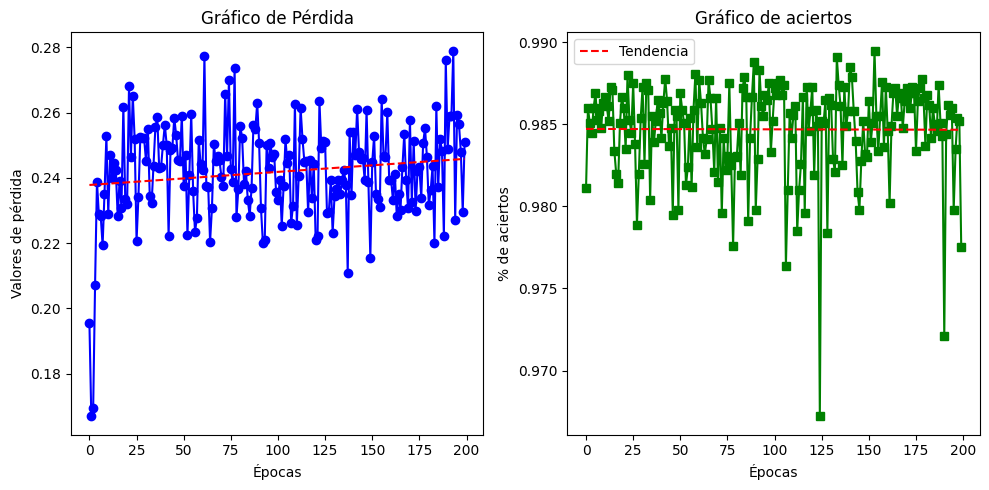

In [16]:
# Creamos la figura y definimos dos subgráficos (1 fila, 2 columnas)
plt.figure(figsize=(10, 5))

# Primer gráfico en la posición 1 (izquierda)
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer gráfico
plt.plot(train_loss, color='blue', marker='o')
plt.title("Gráfico de Pérdida")
plt.xlabel("Épocas")
plt.ylabel("Valores de pérdida")

# Calcular la regresión lineal para train_loss
epochs = np.arange(len(train_loss))
m, b = np.polyfit(epochs, train_loss, 1)
plt.plot(epochs, m*epochs + b, color='red', linestyle='--', label='Tendencia')


# Segundo gráfico en la posición 2 (derecha)
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo gráfico
plt.plot(test_accuracies, color='green', marker='s')
plt.title("Gráfico de aciertos")
plt.xlabel("Épocas")
plt.ylabel("% de aciertos")

# Calcular la regresión lineal para test_accuracies
epochs_test = np.arange(len(test_accuracies))
m, b = np.polyfit(epochs_test, test_accuracies, 1)
plt.plot(epochs_test, m*epochs_test + b, color='red', linestyle='--', label='Tendencia')

# Mostramos los gráficos
plt.tight_layout()  # Ajustamos para que no se solapen los gráficos
plt.legend()
plt.show()